In [1]:
# Install required packages
!pip install pytrends tqdm

In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import requests
from datetime import datetime, timedelta
import time
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [44]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Load movies data
df_movies = pd.read_excel('/content/drive/MyDrive/ekimetrics_case_study/movies.xlsx')

In [46]:
# Display basic info to confirm data load
print(df_movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   150 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB
None


In [47]:
# Set up basic configuration
OMDB_API_KEY = "f710ddc8"

In [48]:
#function to fetch movie details from omdb api
# Function to fetch OMDB data
def fetch_omdb_data(title):
    params = {
        'apikey': OMDB_API_KEY,
        't': title,
        'type': 'movie'
    }
    try:
        response = requests.get('http://www.omdbapi.com/', params=params)
        return response.json() if response.json().get('Response') == 'True' else {}
    except:
        return {}

In [49]:
# Function to safely convert box office string to float
def parse_box_office(value):
    if not value or value == 'N/A':
        return 0
    try:
        # Remove '$' and ',' then convert to float
        return float(value.replace('$', '').replace(',', ''))
    except:
        return 0

# Function to parse release date
def parse_release_date(date_str):
    if not date_str or date_str == 'N/A':
        return None
    try:
        return datetime.strptime(date_str, '%d %b %Y').strftime('%Y-%m-%d')
    except:
        return None

# Modified data collection code
updated_movies = []
for _, row in tqdm(df_movies.iterrows(), total=len(df_movies), desc="Processing movies"):
    title = row['title']

    # Get OMDB data
    omdb_data = fetch_omdb_data(title)
    if not omdb_data:
        continue

    # Extract basic info with safer conversion
    try:
        runtime = int(omdb_data.get('Runtime', '0').split()[0])
    except:
        runtime = 0

    box_office = parse_box_office(omdb_data.get('BoxOffice'))

    try:
        imdb_rating = float(omdb_data.get('imdbRating', 0))
    except:
        imdb_rating = 0

    try:
        imdb_votes = int(omdb_data.get('imdbVotes', '0').replace(',', ''))
    except:
        imdb_votes = 0

    # Get release date
    release_date = parse_release_date(omdb_data.get('Released'))

    release_year = int(omdb_data.get('Year'))

    # Store data
    updated_movies.append({
        'title': title,
        'runtime': runtime,
        'box_office': box_office,
        'imdb_rating': imdb_rating,
        'imdb_votes': imdb_votes,
        'release_date': release_date,
        'release_year': release_year,
    })


# Convert to DataFrame
df_updated = pd.DataFrame(updated_movies)

Processing movies:   0%|          | 0/150 [00:00<?, ?it/s]

In [50]:
# Convert to DataFrame and Save
df_updated = pd.DataFrame(updated_movies)
df_updated.to_excel("/content/drive/MyDrive/ekimetrics_case_study/updated_movies.xlsx", index=False)

In [51]:
df_updated

,title,runtime,box_office,imdb_rating,imdb_votes,release_date,release_year
0,The Age of Adaline,112,42629776.0,7.2,212877,2015-04-24,2015
1,Black Christmas,98,0.0,7.1,50352,1974-12-20,1974
2,London,92,20361.0,6.3,25119,2021-07-03,2005
3,Twisted,97,25198598.0,5.3,23599,2004-02-27,2004
4,Friends with Kids,107,7251073.0,6.1,43369,2012-03-16,2011
...,...,...,...,...,...,...,...
145,National Treasure: Book of Secrets,124,219964115.0,6.5,259750,2007-12-21,2007
146,I Am Mother,113,0.0,6.7,101725,2019-06-07,2019
147,Awake,84,14377198.0,6.5,82099,2007-11-30,2007
148,Book of Dragons,17,0.0,6.6,2419,2011-11-15,2011


In [70]:
# Filter movies: released after 2006 and with box office earnings available
df_movies = df_updated[(df_updated['release_year'] > 2006) & (df_updated['box_office'] > 0)]

In [53]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 0 to 147
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         57 non-null     object 
 1   runtime       57 non-null     int64  
 2   box_office    57 non-null     float64
 3   imdb_rating   57 non-null     float64
 4   imdb_votes    57 non-null     int64  
 5   release_date  57 non-null     object 
 6   release_year  57 non-null     int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 3.6+ KB


In [54]:
pytrends = TrendReq(
    hl='en-US',
    tz=360,
)

In [55]:
#Function to get google trends
def get_google_trends_v2(title, release_date):
    try:
        # Convert release date using the correct format
        release_dt = datetime.strptime(release_date, '%Y-%m-%d')


        end_date = release_dt + timedelta(days=360)

        # Ensure we don't go beyond today
        today = datetime.now()
        if end_date > today:
            end_date = today

        timeframe = f"{release_dt.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}"


        pytrends.build_payload([title],
                             timeframe=timeframe,
                             geo='')

        trends_data = pytrends.interest_over_time()

        time.sleep(60)

        if not trends_data.empty:
            return trends_data[title].mean(), trends_data[title].max(), trends_data[title].sum()
        return 0, 0, 0
    except Exception as e:
        print(f"Error with {title}: {str(e)}")
        return 0, 0, 0


In [56]:
# get google trends data
google_trends_data = []
for _, row in tqdm(df_movies.iterrows(), total=len(df_movies), desc="Processing movies"):
    title = row['title']
    release_date = row['release_date']

    try:
        trends_mean, trends_max, trends_total = get_google_trends_v2(title, release_date)
    except Exception as e:
        print(f"Failed to get trends data for {title}: {str(e)}")

    # Store data
    google_trends_data.append({
        'title': title,
        'release_date': release_date,
        'trends_mean': trends_mean,
        'trends_max': trends_max,
        'trends_total': trends_total
    })


# Convert to DataFrame
google_trends_data_df = pd.DataFrame(google_trends_data)

Processing movies:   0%|          | 0/57 [00:00<?, ?it/s]

Error with The Age of Adaline: The request failed: Google returned a response with code 429
Error with Friends with Kids: The request failed: Google returned a response with code 429
Error with Girls Trip: The request failed: Google returned a response with code 429
Error with The Art of the Steal: The request failed: Google returned a response with code 429
Error with Macbeth: The request failed: Google returned a response with code 429
Error with London Has Fallen: The request failed: Google returned a response with code 429
Error with Anthropoid: The request failed: Google returned a response with code 429
Error with A Quiet Place: The request failed: Google returned a response with code 429
Error with God's Not Dead 2: The request failed: Google returned a response with code 429
Error with Hamlet 2: The request failed: Google returned a response with code 429
Error with Ashby: The request failed: Google returned a response with code 429
Error with Middle Men: The request failed: Go

In [57]:
# pytrends = TrendReq(hl='en-US', tz=0, proxies=["http://158.160.52.208:8090", "http://5.189.174.81:8888"])

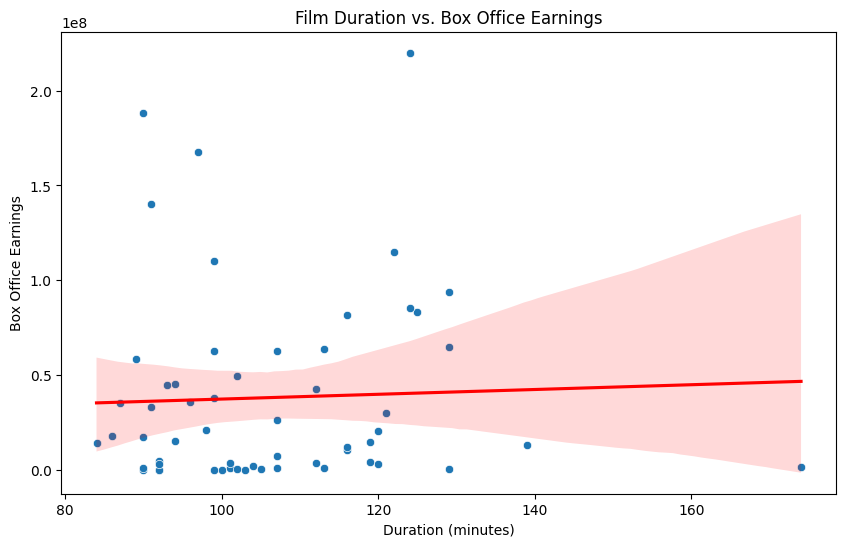

In [78]:
# Analysis 1: Film Length vs. Box Office Earnings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='runtime', y='box_office')
sns.regplot(data=df_movies, x='runtime', y='box_office', scatter=False, color='red')
plt.title('Film Duration vs. Box Office Earnings')
plt.xlabel('Duration (minutes)')
plt.ylabel('Box Office Earnings')
plt.show()

In [79]:
# Calculate correlation coefficient
correlation_length_boxoffice = df_movies['runtime'].corr(df_movies['box_office'])
print(f"Correlation (Duration vs. Box Office): {correlation_length_boxoffice:.2f}")

Correlation (Duration vs. Box Office): 0.04


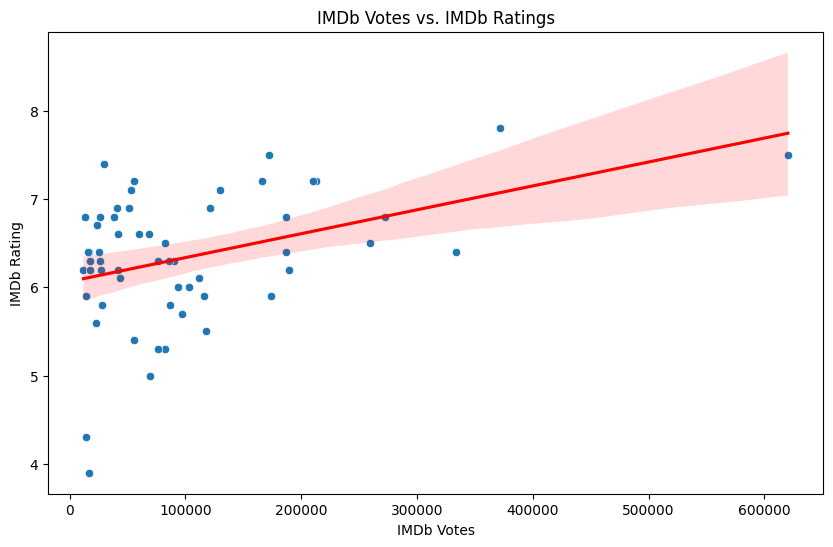

In [80]:
# Analysis 2: IMDb Votes vs. Ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='imdb_votes', y='imdb_rating')
sns.regplot(data=df_movies, x='imdb_votes', y='imdb_rating', scatter=False, color='red')
plt.title('IMDb Votes vs. IMDb Ratings')
plt.xlabel('IMDb Votes')
plt.ylabel('IMDb Rating')
plt.show()

In [81]:
correlation_votes_ratings = df_movies['imdb_votes'].corr(df_movies['imdb_rating'])
print(f"Correlation (IMDb Votes vs. Ratings): {correlation_votes_ratings:.2f}")

Correlation (IMDb Votes vs. Ratings): 0.40
